## Parametric AGN variability model walkthrough

Special requirements:
- xspec
- pyphot

In [1]:
%matplotlib inline
import sys, os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.timeseries import LombScargle

from tqdm.notebook import tqdm

import scipy.stats as st

from multiprocessing import Pool

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import xspec
#import pyphot
from pyphot import astropy as pyphot
from labellines import labelLine, labelLines

# https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html#optxagnf
xspec.Xset.allowPrompting = False

from model import DemographicModel, ERDF_blue, ERDF_red, calc_sigma_var, lambda_obs, get_AGN_flux, get_RIAF_flux

In [2]:
def set_mpl_style():
    
    """Function to set MPL style"""
    
    fsize = 15
    tsize = 18
    tdir = 'in'
    major = 5.0
    minor = 3.0
    lwidth = 1.8
    lhandle = 2.0
    plt.style.use('default')
    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.size'] = fsize
    plt.rcParams['legend.fontsize'] = tsize
    plt.rcParams['xtick.direction'] = tdir
    plt.rcParams['ytick.direction'] = tdir
    plt.rcParams['xtick.major.size'] = major
    plt.rcParams['xtick.minor.size'] = minor
    plt.rcParams['ytick.major.size'] = 5.0
    plt.rcParams['ytick.minor.size'] = 3.0
    plt.rcParams['axes.linewidth'] = lwidth
    plt.rcParams['legend.handlelength'] = lhandle
    
    return

In [3]:
set_mpl_style()

### Parameteric Variability Prescription

Follows MacLeod et al. 2010, Suberlak et al. 2021:

$$
    \log\left(\frac{{\rm{SF}}_{\infty}}{\rm{mag}}\right) = A + B\ \log\left(\frac{\lambda_{\rm{RF}}}{4000\ {\overset{\circ}{A}}}\right) + 
    C\ (M_i + 23) + D\ \log\left(\frac{M_{\rm{BH}}}{10^9\ M_{\odot}}\right)
$$

where $A = -0.51 \pm 0.02$, $B = -0.479 \pm 0.005$, $C = 0.131 \pm 0.008$, and $D = 0.18 \pm 0.03$; and,

$$
    \log\left(\frac{\tau}{\rm{days}}\right) = A + B\ \log\left(\frac{\lambda_{\rm{RF}}}{4000\ \overset{\circ}{A}}\right) + 
    C\ (M_i + 23) + D\ \log\left(\frac{M_{\rm{BH}}}{10^9\ M_{\odot}}\right)
$$

where ${\rm{SF}}_{\infty}$ is the structure function (SF) evaluated at infinity (i.e., asymptotic rms variability amplitude; e.g., Kozlowski 2016) and $A = 2.4 \pm 0.2$, $B = 0.17 \pm 0.02$, $C = 0.03 \pm 0.04$, and $D = 0.21 \pm 0.07$ (Suberlak et al. 2021). Except we adopt the coefficients of $A=2.029\pm0.004$, $D=0.38\pm0.05$ and pivot mass from Burke et al. 2021 which includes dwarf AGNs. In these relations, $\lambda_{\rm{RF}}$ is the rest-frame wavelength of the observation and $M_i$ refers to the $i$-band absolute magnitude $K$-corrected to $z=2$, $M_i(z{=}2)$, as a proxy for the AGN bolometric luminosity $L_{\rm{bol}}$ following (Richards et al. 2006). As such, we adopt the relation $M_i = 90 - 2.5\ \log(L_{\rm{bol}}\ /\ {\rm{erg\ s}^{-1}})$ (Shen et al. 2013) instead of the actual value computed from the SED in these relations so that this variable still acts as a linear proxy for $\log\ L_{\rm{bol}}$ when extrapolated to low black hole masses.

#### Extension to low-mass AGN

in the IMBH regime, host galaxy light will dominate, diluting the variability amplitude from the AGN emission. To estimate the host galaxy light dilution, we use the $M_{\rm{BH}}-M_{\star}$ relation of (Reines et al. 2015) and use stellar mass-to-light ratios of (Zibetti et al. 2009) which requires a host galaxy color index (e.g., $g-r$) and contamination factor of $f_\star$ (i.e., covering factor, accounting for aperture effects) such that the luminosity enclosed in an aperture is $L_{\star, {\rm{ap}}} = f_\star\ L_{\star}$. The resulting observed (diluted) rms variability amplitude is,

$$
    {\rm{SF}}_\infty^{\prime} = \frac{2.5}{\ln(10)} \frac{\Delta L}{L_{\rm{AGN}}+ f_\star L_{\star}}
$$
where,
$$
    \Delta L = L_{\rm{AGN}} \frac{\ln(10)}{2.5} \rm{SF}_\infty
$$
where $L_{\rm{AGN}}$ is the AGN luminosity (assumed to be a point source), $L_{\star}$ is the host galaxy luminosity in a given band, and $\rm{SF}_\infty$ is given by the quation above.


To summarize, we need:

- Black hole mass: $M_{\rm{BH}}$ (e.g., from $M_{\rm{BH}} - M_{\star}$ relation)
- Rest-frame wavelength: $\lambda_{\rm{RF}}$
- Bolometric luminosity or $M_i(z=2)$ (i.e., Eddington ratio)

Dilution parameters:

- AGN (accretion disk) luminosity in band $L_{\rm{AGN}}$
- Host galaxy luminosity in band $L_\star$
- Covering factor $f_\star$

To obtain the need the AGN luminosity in a given band at varying masses, which we use the color-temperature-corrected AGN model of Done et al. 2012.

In [6]:
lib = pyphot.get_library()

# if lamb_T has units the Filter object will use those.
#f = pyphot.Filter(lamb_T, T, name='my_filter', dtype='photon', unit='Angstrom') # Import Rubin filters
f = lib['SDSS_g']

0.00701593806109562
optxagnf ['mass', 'dist', 'logLoLEdd', 'astar', 'rcor', 'logrout', 'kT_e', 'tau', 'Gamma', 'fpl', 'Redshift', 'norm']
39.56499625040433 39.10037054511756
41.56431960848837 41.10037054511756
43.562495833205105 43.10037054511756
45.55783773477498 45.10037054511756
diskir ['kT_disk', 'Gamma', 'kT_e', 'LcovrLd', 'fin', 'rirr', 'fout', 'logrout', 'norm']
0.10000036132738777


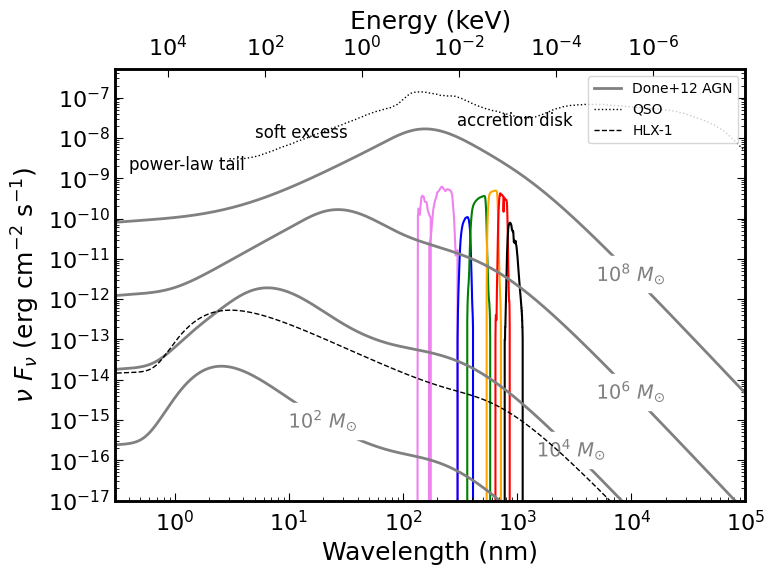

In [7]:
import matplotlib

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax_top = ax.twiny()
lines = []

d_c = 30*u.Mpc # Comoving (proper) distance

from astropy.cosmology import z_at_value
z = z_at_value(cosmo.comoving_distance, d_c)
print(z)
d_L = cosmo.luminosity_distance(z)

lambda_Edd = 0.1

# Parameters
model_pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
        'log_r_out':4,'kT_e':0.23,'tau':11,'gamma':2.2,'f_pl':0.05,'z':z,'norm':1}
bh_masses = [1e2, 1e4, 1e6, 1e8]*u.Msun

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")

# Print parameter names
ncomp = len(model_sed.componentNames)
for icomp in model_sed.componentNames:
    print(icomp, eval(f'model_sed.{icomp}.parameterNames'))

for i, M_BH_i in enumerate(bh_masses):
    
    model_pars['bh_mass'] = M_BH_i.to(u.Msun).value
    model_sed.setPars(list(model_pars.values()))
    energies = model_sed.energies(0)[::-1]*u.keV # Why N-1?
    # RF -> Obs. frame
    wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
    dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))
    
    # E N_E dlogE to nu f_nu
    """
    dlogE = np.diff(np.log10(energies[::-1].value))
    sed = model_sed.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
    nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))
    """
    
    # Use AGN SED
    M_band, m_band, L_AGN_band, f_band, nuf_nu = get_AGN_flux(model_sed, model_pars['bh_mass'], lambda_Edd, z=z)
    
    # Make sure the bolmetric luminosities are reasonably close
    f_lambda = (nuf_nu*u.erg/u.s/u.cm**2)/wav
    L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
    L_bol = (lambda_Edd*1.26e38*u.erg/u.s*M_BH_i/(1*u.Msun)).to(u.erg/u.s)
    # \int f_lambda T dlambda = [erg/s/AA] [AA]
    #print(np.log10(np.trapz(L_lambda.to(u.erg/u.s/u.AA), x=wav.to(u.AA)).value))
    print(np.log10(np.sum(L_lambda*dwav).value), np.log10(L_bol.value))
    
    s = f'$10^{int(np.log10(M_BH_i.to(u.Msun).value))}$'+r'$\ M_{\odot}$'
    lines.extend(ax.loglog(wav.value, nuf_nu, color='gray', lw=2, label=s))
    ax_top.loglog(energies.value[:-1], nuf_nu, alpha=0, lw=2)
    
    
labelLines(lines, zorder=2.5, fontsize=14, align=False,
           backgroundcolor='white', xvals=[2e1,3e3,1e4,1e4]*len(lines)) #, drop_label=True)
    
ys = 2
ax.text(3e2, 1e-8*ys, 'accretion disk', fontsize=12)
ax.text(5e0, 5e-9*ys, 'soft excess', fontsize=12)
ax.text(4e-1, 8e-10*ys, 'power-law tail', fontsize=12)


# Irradiated-disk model (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node164.html)
# Parameters
#z = z_at_value(cosmo.comoving_distance, 95*u.Mpc)
#d_L = cosmo.luminosity_distance(z)

model_pars = {'kT_disk':0.17,'Gamma':2.1,'kT_e':100,'Lc/Ld':0.07,'fin':0.0,
        'rirr':1.0001,'fout':0.0013,'logrout': 3.7, 'norm':50}
#M_BH_HLX1 = 1e2*u.Msun

model_sed_HLX1 = xspec.Model("diskir")
#pars['bh_mass'] = M_BH_HLX1.to(u.Msun).value

# Print parameter names
ncomp = len(model_sed_HLX1.componentNames)
for icomp in model_sed_HLX1.componentNames:
    print(icomp, eval(f'model_sed_HLX1.{icomp}.parameterNames'))

model_sed_HLX1.setPars(list(model_pars.values()))
energies = model_sed_HLX1.energies(0)[::-1]*u.keV # Why N-1?
# RF -> Obs. frame
wav = (energies[:-1]).to(u.nm, equivalencies=u.spectral())*(1 + z)
dwav = np.diff((energies).to(u.AA, equivalencies=u.spectral())*(1 + z))

# E N_E dlogE to nu f_nu
dlogE = np.diff(np.log10(energies[::-1].value))
sed = model_sed_HLX1.values(0)[::-1]/dlogE * u.photon/u.cm**2/u.s 
nuf_nu = sed.to(u.erg/u.cm**2/u.s, equivalencies=u.spectral_density(wav))

nuf_nu = nuf_nu*(30/95)**-2*(0.1/1.945) # Rescale to 30 Mpc and L/LEDD = 0.1
f_lambda = nuf_nu/wav
L_lambda = (f_lambda*4*np.pi*d_L**2).to(u.erg/u.s/u.AA)
L_bol = np.sum(L_lambda*dwav).value
L_Edd = 1.26e38 * 1e4
print(L_bol/L_Edd)

line_AGN, = ax.loglog([-10,-10], [0,0], color='gray', lw=2, label='Done+12 AGN')


line_HLX1, = ax.loglog(wav.value, nuf_nu.value, color='k', lw=1, linestyle='dashed', zorder=10, label='HLX-1')

# ### Richards SED ####
from astropy.io import ascii
data_richards = ascii.read("richards_sed.txt")
f_richards = 10**data_richards['LogF'].data*u.Hz
nuL_nu_richards = 10**data_richards['OptLum'].data*u.erg/u.s

wav = (f_richards).to(u.nm, equivalencies=u.spectral())*(1 + z)
nuf_nu = (nuL_nu_richards/(4*np.pi*d_L**2)).to(u.erg/u.s/u.cm**2)

line_QSO, = ax.loglog(wav.value, nuf_nu.value, color='k', lw=1, linestyle='dotted', zorder=10, label='QSO')

#####


# Plot bandpasses
colors = ['violet','violet','blue','green','orange','red','black']
bandpasses = ['GALEX_FUV','GALEX_NUV','SDSS_u','SDSS_g','SDSS_r','SDSS_i','SDSS_z']
for i, f in enumerate(bandpasses):
    bandpass = lib[f]
        
    wav_band = (bandpass.wavelength).to(u.nm).value
    wav_band = [np.min(wav_band) - 1e-2] + list(wav_band) + [np.max(wav_band) + 1e-2]
    trans = bandpass.transmit
    trans = [0] + list(trans) + [0]
    
    ax.plot(wav_band, np.array(trans)*1e-9, color=colors[i], zorder=-10)

ax.set_ylim(1e-17, 5e-7)
ax.set_xlim(3e-1, 1e5)

#ax2.set_ylim(1e-14, 1e0)

ax_top.set_xlim(np.max(energies.value), np.min(energies.value))

ax.set_xlabel(r'Wavelength (nm)', fontsize=18)
ax.set_ylabel(r'$\nu\ F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=18)
ax_top.set_xlabel(r'Energy (keV)', fontsize=18)


for ax in [ax, ax_top]:

    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)
    
ax.legend(handles=[line_AGN, line_QSO, line_HLX1], fontsize=10, loc='upper right')


# Why doesn't this seem to work?
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax_top.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax_top.xaxis.set_minor_locator(locmin)
ax_top.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
fig.savefig('sed.pdf', dpi=300)

### Extension to RIAFs (Low-luminosity AGNs and LINERs)

In [32]:
# TODO, will use this model
# https://github.com/rsnemmen/riaf-sed

### Plot $M_i$ versus black hole mass

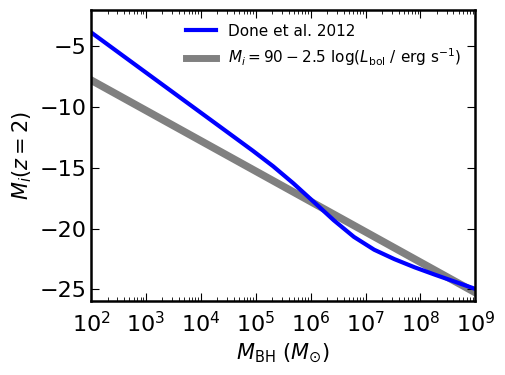

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5.3,4))

lambda_Edd = 0.1

L_bol = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
M_i_AGN_Shen = np.array([90 - 2.5*np.log10(L_bol/(1*u.erg/u.s)) + np.random.normal(0, 0.166)
                         for i in range(size)]) # M_i(z=2) Shen

ax.plot(M_BH, M_i_AGNs[f'{lambda_Edd}'], c='b', lw=3, label='Done et al. 2012')
ax.plot([1e0], [1e0], c='gray', lw=5, label=r'$M_i = 90 - 2.5\ \log(L_{\rm{bol}}\ /\ \rm{erg}\ \rm{s}^{-1})$') # Fake line
ax.fill_between(M_BH.value, np.percentile(M_i_AGN_Shen, 16, axis=0), np.percentile(M_i_AGN_Shen, 84, axis=0),
                color='gray', lw=3)

# Fit a line to the M_i_AGN curve
"""
mask = M_BH < 1e6*u.Msun
slope, intercept, r, p, se = st.linregress(np.log10(L_bol.value[mask]), M_i_AGNs[f'{lambda_Edd}'][mask])
print(slope, intercept)
# Approximate with some nice round numbers
ax.plot(M_BH, 125 - 3.3*np.log10(L_bol.value))
"""

ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$M_i(z{=}2)$')
ax.legend(fontsize=11, frameon=False)
ax.tick_params(axis='x', which='major', pad=7)

ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlim(1e2, 1e9)
ax.set_ylim(-26, -2)


locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
fig.savefig('Mi.pdf', dpi=300)

### Demonstration of variability amplitude vs. black hole mass

Read the SDSS data from MacLeod et al. 2010:

In [9]:
from astropy.io import ascii
dat = ascii.read('s82drw_g.dat')

# http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern_format_drw.html

tau_drw = 10**dat['col8']*u.day
z = dat['col4']

Mi = dat['col5']
edge = dat['col14']
Plike = dat['col15']
Pnoise = dat['col16']
Pinf = dat['col17']
Pmu = dat['col18']

M_BH_Macleod = (10**dat['col6'])

#mask = (dat['col9'] != -10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)
mask = (dat['col9'] != -10) & (edge == 0) & ((Plike-Pnoise) > 2) & ((Plike-Pinf) > 0.05) & (M_BH_Macleod > 1) & (z > 0) & (tau_drw.value > 10) #& (tau_drw_Macleod*(1+z) < 0.2*365*10*u.day)

z_Macleod = z[mask]
M_BH_Macleod = (10**dat['col6']*u.Msun)[mask]
tau_drw = tau_drw.to(u.year).value
SF_inf = 10**dat['col9'] * np.sqrt(tau_drw)
SF_inf_Macleod = SF_inf[mask] # log sigma
Mi_Macleod = Mi[mask]
L_bol_Macleod = 10**(-(Mi_Macleod - 90)/2.5)
lambda_Edd_Macleod = L_bol_Macleod/(1.26e38*(M_BH_Macleod/(1*u.Msun)))

## ZTF
dat = ascii.read('G_sigdrw_highquality.txt')
SF_inf_ZTF = np.sqrt(2)*dat['sigD']
M_BH_ZTF = 10**dat['mass']

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


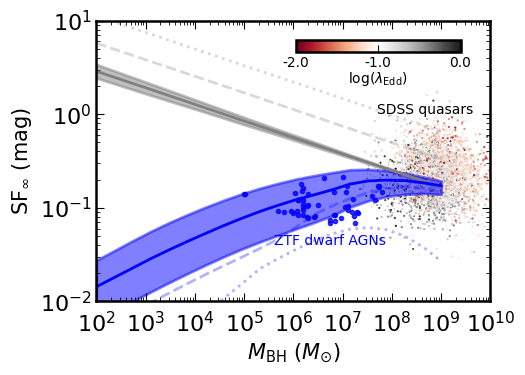

In [10]:
from model import get_AGN_flux, draw_SFinf, g_minus_r_model, f_host_model
import matplotlib

#def g_minus_r_model(M_stellar, a=10.29707842, b=1.2622896, c=-0.2116654, seed=None):
#    np.random.seed(seed)
#    x = np.log10(M_stellar) - a
#    return b**x + c + np.random.normal(0, 0.34/4, size=len(M_stellar))

# Parameters
#model_pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
#        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")


# Plot
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux, otypes=[np.float,np.float,np.float,np.float,np.ndarray])

size = 200
M_BH = np.logspace(2, 9, 20)*u.Msun
lambda_Edds = [0.1, 0.01, 0.001]

z_ex = 0.007 # ~30 Mpc # quasar: 0.5
f_host = 0.2 #0.5 # host contaimination level

band = 'SDSS_g'
g_minus_r = 0.4 # 0.2 - 0.8 # quasar: 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

M_i_AGNs = {}
        

for lambda_Edd in lambda_Edds:

    M_band_AGN, m_band_AGN, L_band_AGN, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
    M_i_AGN, _, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
        
    M_i_AGNs[f'{lambda_Edd}'] = M_i_AGN
    
    L_bol_AGN = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
    M_i_AGN = 90 - 2.5*np.log10(L_bol_AGN.to(u.erg/u.s).value)
    
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = draw_SFinf(np.array([lambda_RF.to(u.AA).value]), np.array([M_i_AGN]),
                                np.array([M_BH.value]), size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if lambda_Edd == 0.1:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            #g_minus_r = g_minus_r_model(M_stellar.value)
            #f_host = f_host_model(np.array([z_ex]))
            #L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
            L_band_host = f_host * M_stellar/(1*u.Msun) / (10**(1.654*g_minus_r - 0.840 + np.random.normal(0.0, 0.3))) *u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(1.654*g_minus_r - 0.840)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]*1.3
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if lambda_Edd == 0.1:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH.value, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH.value, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif lambda_Edd == 0.01:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2, linestyle='dashed', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    else:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='grey', lw=2, linestyle='dotted', alpha=0.3)
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)


l = np.log10(lambda_Edd_Macleod)
c_norm = (l - -2)/(0 - -2) # -2 and 0 are the limits
c_norm = np.clip(c_norm, 0, 1)
sc = ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, c=c_norm, cmap='RdGy', zorder=-11, label='SDSS quasars')
ax.text(5e7, 1e0, 'SDSS quasars', fontsize=10)
ax.text(4e5, 4e-2, 'ZTF dwarf AGNs', fontsize=10, color='blue')


ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

# colorbar
cax = fig.add_axes([0.56, 0.84, 0.3, 0.03])
fig.colorbar(sc, cax=cax, orientation='horizontal')
cax.tick_params(axis='both', which='both', direction='in', labelsize=10)
cax.set_xlabel(r'$\log(\lambda_{\rm{Edd}})$', fontsize=10, labelpad=0)
cax.set_xticklabels([-2.0, -1.0, 0.0])


# ticks
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

# labels and limits
ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

#ax.legend(fontsize=10, loc='upper right')
ax.tick_params(axis='x', which='major', pad=7)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
#fig.savefig('SFinf.pdf', dpi=300)

/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/colinjb2/.local/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


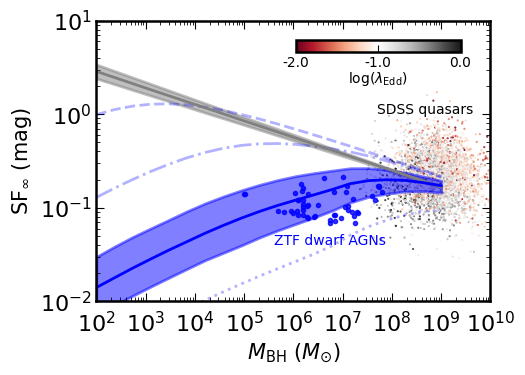

In [11]:
from model import get_AGN_flux, draw_SFinf, g_minus_r_model, f_host_model
import matplotlib

#def g_minus_r_model(M_stellar, a=10.29707842, b=1.2622896, c=-0.2116654, seed=None):
#    np.random.seed(seed)
#    x = np.log10(M_stellar) - a
#    return b**x + c + np.random.normal(0, 0.34/4, size=len(M_stellar))

# Parameters
#model_pars = {'bh_mass':1e8,'dist_c':d_c.to(u.Mpc).value,'lambda_edd':np.log10(lambda_Edd),'spin':0,'r_cor':100,
#        'log_r_out':-1,'kT_e':0.2,'tau':10,'gamma':1.8,'f_pl':0.25,'z':z,'norm':1}

# Set energy range
e0 = (1e8*u.nm).to(u.keV, equivalencies=u.spectral())
e1 = (1e-5*u.nm).to(u.keV, equivalencies=u.spectral())
xspec.AllModels.setEnergies(f"{e0.value} {e1.value} 1000 log")
# Comptonized disk (https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node205.html)
model_sed = xspec.Model("optxagnf")


# Plot
fig, ax = plt.subplots(1, 1, figsize=(5.5,4), sharex=True)

vget_AGN_flux = np.vectorize(get_AGN_flux, otypes=[np.float,np.float,np.float,np.float,np.ndarray])

size = 200
M_BH = np.logspace(2, 9, 20)*u.Msun

# adjusting redshift will change the luminosity of the AGN, and affect the dilution
z_ex = 0.007 # ~30 Mpc
f_hosts = [0.002, 0.02, 0.2, 1.0] # host contaimination level

band = 'SDSS_g'
g_minus_r = 0.4 # 0.2 - 0.8

lambda_RF = lib[band].lpivot/(1 + z_ex)

M_i_AGNs = {}
lambda_Edd = 0.1

for f_host in f_hosts:

    M_band_AGN, m_band_AGN, L_band_AGN, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=z_ex, band=band)
    M_i_AGN, _, _, _, _ = vget_AGN_flux(model_sed, M_BH.value, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
        
    M_i_AGNs[f'{lambda_Edd}'] = M_i_AGN
    
    L_bol_AGN = lambda_Edd*1.26e38*(M_BH/(1*u.Msun))*u.erg/u.s
    M_i_AGN = 90 - 2.5*np.log10(L_bol_AGN.to(u.erg/u.s).value)
    
    SFinf = np.empty([size, len(M_BH)])
    SFinf_host = np.empty([size, len(M_BH)])
        
    for i in range(size):
        # No host contaimination
        SFinf[i,:] = draw_SFinf(np.array([lambda_RF.to(u.AA).value]), np.array([M_i_AGN]),
                                np.array([M_BH.value]), size=1) # Delta mag

        # Use the host M/L ratio to get M_i
        #M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 8.95)/1.40)
        if f_host == 0.2:
            # Randomize
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun) + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
            #g_minus_r = g_minus_r_model(M_stellar.value)
            #f_host = f_host_model(np.array([z_ex]))
            #L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
            L_band_host = f_host * M_stellar/(1*u.Msun) / (10**(1.654*g_minus_r - 0.840 + np.random.normal(0.0, 0.3))) *u.Lsun
        else:
            M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH/(1*u.Msun)) - 7.45)/1.05)
            L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(1.654*g_minus_r - 0.840)*u.Lsun

        # Including host contaimination
        dL = L_band_AGN*np.log(10)/2.5*SFinf[i,:]*1.3
        SFinf_host[i,:] =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host) # These are actually g-band

    # Plot
    if f_host == 0.2:
        ax.loglog(M_BH, np.median(SFinf, axis=0), color='gray', lw=2)
        ax.fill_between(M_BH.value, np.percentile(SFinf, 16, axis=0), np.percentile(SFinf, 84, axis=0),
                        color='gray', lw=2, alpha=0.5)

        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2)
        ax.fill_between(M_BH.value, np.percentile(SFinf_host, 16, axis=0), np.percentile(SFinf_host, 84, axis=0),
                        color='b', lw=2, alpha=0.5)
    elif f_host == 0.02:
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashdot', alpha=0.3)
    elif f_host == 0.002:
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dashed', alpha=0.3)
    else:
        ax.loglog(M_BH, np.median(SFinf_host, axis=0), color='b', lw=2, linestyle='dotted', alpha=0.3)
        
# SDSS quasars
l = np.log10(lambda_Edd_Macleod)
c_norm = (l - -2)/(0 - -2)
c_norm = np.clip(c_norm, 0, 1)
sc = ax.scatter(M_BH_Macleod, SF_inf_Macleod, marker='.', s=1, c=c_norm, cmap='RdGy', zorder=-11, label='SDSS quasars')
ax.text(5e7, 1e0, 'SDSS quasars', fontsize=10)
ax.text(4e5, 4e-2, 'ZTF dwarf AGNs', fontsize=10, color='blue')

ax.scatter(M_BH_ZTF, SF_inf_ZTF, marker='.', color='b', alpha=0.8, label='ZTF dwarf AGNs', zorder=-10)

# colorbar
cax = fig.add_axes([0.56, 0.84, 0.3, 0.03])
fig.colorbar(sc, cax=cax, orientation='horizontal')
cax.tick_params(axis='both', which='both', direction='in', labelsize=10)
cax.set_xlabel(r'$\log(\lambda_{\rm{Edd}})$', fontsize=10, labelpad=0)
cax.set_xticklabels([-2.0, -1.0, 0.0])

# ticks
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_xlabel(r'$M_{\rm{BH}}\ (M_{\odot})$')
ax.set_ylabel(r'$\rm{SF}_{\infty}$ (mag)')
ax.set_xlim([1e2, 1e10])
ax.set_ylim([1e-2, 1e1])

#ax.legend(fontsize=10, loc='upper right')
ax.tick_params(axis='x', which='major', pad=7)

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

fig.tight_layout()
#fig.savefig('SFinf2.pdf', dpi=300)

### Mock light curves:

In [12]:
def generate_damped_RW(t_rest, tau=300., z=2.0,
                       xmean=0, SFinf=0.3, random_state=None):
    #  Xmean = b * tau
    #  SFinf = sigma * sqrt(tau / 2)
    t_rest = np.atleast_1d(t_rest)

    if t_rest.ndim != 1:
        raise ValueError('t_rest should be a 1D array')

    #random_state = check_random_state(random_state)

    N = len(t_rest)

    t_obs = t_rest * (1. + z) / tau

    x = np.zeros(N)
    x[0] = np.random.normal(xmean, SFinf)
    E = np.random.normal(0, 1, N)

    for i in range(1, N):
        dt = t_obs[i] - t_obs[i - 1]
        x[i] = (x[i - 1]
                - dt * (x[i - 1] - xmean)
                + np.sqrt(2) * SFinf * E[i] * np.sqrt(dt))

    return x

### Example rest-frame light curves

In [26]:
from model import draw_tau, simulate_drw

def simulate_lc(t_rest, z=0.0, M_BH=1e6, lambda_Edd=0.1, band='SDSS_g', f_host=0.2,  g_minus_r=0.6, randomize=True):
    
    lambda_RF = lib[band].lpivot/(1 + z)
    
    M_band_AGN, m_band_AGN, L_band_AGN, f_band_AGN, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=z, band=band)
    M_i_AGN, _, _, _, _ = get_AGN_flux(model_sed, M_BH, lambda_Edd=lambda_Edd, z=2.0, band='SDSS_i')
    L_band_AGN = L_band_AGN*u.erg/u.s
    
    # SF_\infy
    SFinf = draw_SFinf(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    tau = draw_tau(lambda_RF.to(u.AA).value, M_i_AGN, M_BH, size=1, randomize=randomize)
    print(tau)
    
    # Use the host M/L ratio to get M_i
    if randomize:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH + np.random.normal(0.0, 0.5)) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030 + np.random.normal(0.0, 0.3))*u.Lsun
    else:
        M_stellar = 1e11*u.Msun * 10**((np.log10(M_BH) - 7.45)/1.05)
        L_band_host = f_host * M_stellar/(1*u.Msun) / 10**(2.053*g_minus_r - 1.030)*u.Lsun
    
    # Including host contaimination
    dL = L_band_AGN*np.log(10)/2.5*SFinf
    SFinf =  2.5/np.log(10)*dL/(L_band_AGN + L_band_host)
    
    return generate_damped_RW(t_rest, tau, z, m_band_AGN, SFinf)

2.024343830250697
7.37499472163306
25.97280924818197


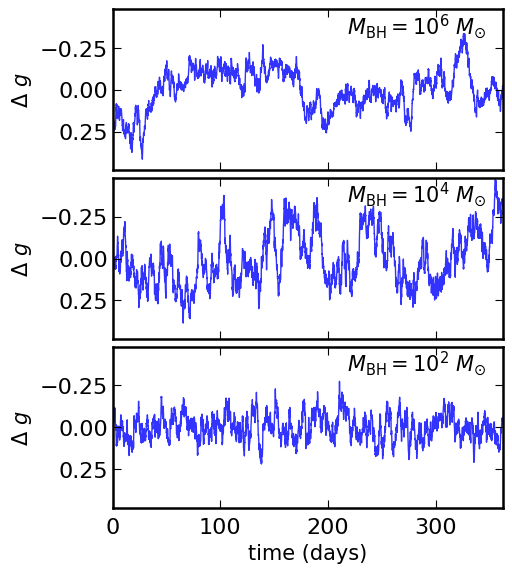

In [27]:
z_ex = 0.007 # ~30 Mpc

d_L = cosmo.luminosity_distance(z_ex).to(u.cm)
t_obs = np.arange(0, 365*1, .1)

M_BHs = [1e2, 1e4, 1e6]*u.Msun

nex = len(M_BHs)
fig, axs = plt.subplots(nex, 1, figsize=(5,2*nex), sharex=True)


for i, M_BH_i in enumerate(M_BHs):
    # Get the stellar mass
    t_rest = t_obs/(1 + z_ex)
    y = simulate_lc(t_rest, z=z_ex, M_BH=M_BH_i.value, lambda_Edd=0.1, band='SDSS_g', randomize=False)
    ax = axs[len(M_BHs) - 1 - i]
    y = y-np.mean(y)
    
    s = r'$M_{\rm{BH}} = '+f'10^{int(np.log10(M_BH_i.value))}$'+r'$\ M_{\odot}$'
    ax.text(0.6, 0.85, s, transform=ax.transAxes, color='k', zorder=1)
    ax.errorbar(t_rest, y, color='b', lw=1, zorder=0, alpha=0.8)
    ax.set_ylabel(r'$\Delta\ g$')
    ax.set_xlim(np.min(t_rest), np.max(t_rest))
    ax.set_ylim(np.mean(y)+0.48, np.mean(y)-0.48)
    
    ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='major', pad=7)

axs[-1].set_xlabel('time (days)')
fig.tight_layout()
fig.subplots_adjust(hspace=.05, left=0.2, right=0.98)
#fig.savefig('lc_examples.pdf', dpi=300)

### Eddinton ratio distribution

We adopt a broken power-law distribution for the Eddington luminosity ratio ($\lambda_{\rm{Edd}} \equiv L_{\rm{bol}}/L_{\rm{Edd}}$) probability distribution function to compute the AGN bolometric luminosity $L_{\rm{bol}}$ from this. Specifically, we adopt the commonly used double power-law parameterization:
$$
    \xi(\lambda_{\rm{Edd}}) = \xi^\ast \left[\left(\frac{\lambda_{\rm{Edd}}}{\lambda_{\rm{Edd}}^\ast}\right)^{\delta_1} + \left(\frac{\lambda_{\rm{Edd}}}{\lambda_{\rm{Edd}}^\ast}\right)^{\delta_2}\right]^{-1}
$$
where $\xi(\lambda_{\rm{Edd}})$ is the Eddingtion ratio distribution function (ERDF), $\lambda_{\rm{Edd}}^\ast$ is the break Eddingtion ratio, and $\delta_1$ and $\delta_2$ are the shallow and steep power law exponents, respectively.

There is evidence that the red and blue galaxy populations have different accretion modes. Weigel et al. 2017 found that the radio AGN luminosity function (predominately red host galaxies) are described by a broken power law ERDF favoring lower accretion rates. On the other hand, the X-ray AGN luminosity function (predominately blue host galaxies) described by a broken power law ERDF favoring relatively higher accretion rates. They interpret this as evidence for a mass-independent ERDF for red and blue galaxies with radiatively inefficient and efficient accretion modes, respectively. We adopt the best-fit parameters for the high-end slope and break Eddington ratio for the red and blue galaxy populations $\delta_2$, and $\log\ \lambda^\ast$ from (Weigel et al. 2017), in order to match constraints on the $z\approx0$ AGN bolometric luminosity function (e.g.,Ajello et al. 2012, Aird et al.2015).

The normalization of the ERDF $\xi^\ast$ determines how many of the $N_{\rm{draw, BH}}$ black hole mass values are assigned an Eddington ratio as well as an AGN duty cycle.

### Optical Type 1 fraction

Type 2 (highly optically obscured) AGNs show little or no detectable optical variability because their UV/optical accretion disk emission is thought to be obscured (Barth 2014). We adopt the luminosity-dependent optically obscured AGN fraction $f_{\rm{obs}}$ from Merloni et al. 2014:
$$
    f_{\rm{obs}}(l_x) = A + \frac{1}{\pi} \tan^{-1}\left(\frac{l_0 - l_x}{\sigma_x}\right)
$$
where $l_x = \log(L_{X} / {\rm{erg}\ {s}^{-1}})$ and their best-fit parameters from their X-ray selected sample are $A=0.56$, $l_0 = 43.89$, an $\sigma_x=0.46$. However, we adopt the normalization $A=0.5$ to ensure $f_{\rm{obs}}$ asymptotes to unity at low luminosity. Formal uncertainties are not given by (Merloni et al. 2014), but the uncertainties in their luminosity bins are $\sim0.2$ dex in luminosity. We show the optically-obscured fraction as function of $L_{\rm{bol}}$ using the luminosity-dependent $2{-}10$ keV bolometric correction of Duras et al. 2020. We randomly assign each $N_{\rm{draw, BH}}$ sources in our Monte Carlo model to be optically obscured or unobscured using the probability function. We simply set the AGN luminosity to zero for optically obscured sources, ensuring their variability would be undetectable ($\rm{SF}_\infty^\prime \approx 0$ for $L_{\rm{AGN}}/f_{\star}\ L_{\star} << 1$).

### Extreme variability quasars

#### 1. Changing-look/changing-state AGNs

Use the SSD accretion disk viscosity timescale: https://ui.adsabs.harvard.edu/abs/2021ApJ...921...70S/abstract

scales like: $t_{\rm{vis}} \sim M_{\rm{BH}}^{1/2}$

It's also consistent with the much larger fraction of changing-state AGNs found in dwarf galaxies (Baldassare et al. 2020)

#### 2. Flares in AGNs

Rates constrained by: https://ui.adsabs.harvard.edu/abs/2017MNRAS.470.4112G/abstract

- other stellar processes (SN, TDE, etc.)
- turn-on CL AGNs
- microlensing